# Getting the MODIS data

MODIS (Moderate Resolution Imaging Spectroradiometer) is an instrument on two of NASA's satellites that monitors various qualities of light coming from Earth\footnote{https://modis.gsfc.nasa.gov/about/}. The raw data is processed by an algorithm developed in 2003 into a list of pixels that burn at any given time. Each satellite passes over each region twice, so there will be 4 rounds of detections every day.

In [5]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import cPickle
import os
REP_DIR = "/Users/zbutler/research/fire_prediction/"
os.chdir(REP_DIR)
from data import data
import matplotlib
%matplotlib inline

To acquire the raw data:
1. Log on to the FTP serer fuoco.geog.umd.edu
2. Log in with the username "fire" and password "burnt"
3. Navigate to the directory /modis/C6/mcd14ml
4. Files will be compressed CSVs of the form MCD14ML.YYYYMM.006.01.txt.gz
To learn more, check out the user guide at http://modis-fire.umd.edu/files/MODIS_C6_Fire_User_Guide_A.pdf

I've downloaded this data and converted it into a pandas DataFrame (stored as a pickle) for easy use. I'll demonstrate it here

In [9]:
with open("data/ak_fires.pkl") as fmodis:
    ak_modis = cPickle.load(fmodis)
print "loaded DataFrame with %d rows" % (len(ak_modis))
ak_modis.iloc[0:5]

loaded DataFrame with 96218 rows


,confidence,day,frp,hour,lat,lon,minute,month,year,x,y,dayofyear
1448868,0.24,1,7.1,22,64.808,-147.609,19,5,2007,1046.361463,1088.688,121
1600851,0.53,17,13.3,22,60.046,-151.492,33,5,2007,862.434548,560.106,137
1610427,0.43,19,23.8,23,67.019,-158.293,44,5,2007,566.748464,1334.109,139
1623204,0.35,21,4.5,20,62.808,-138.762,16,5,2007,1509.981794,866.688,141
1628928,0.81,21,16.8,22,63.922,-146.422,9,5,2007,1110.487294,990.342,141


Each row in the DataFrame represents one active fire detection. I've done some extra processing, the columns are as follows:
* minute/hour/day/month/year: day of this active fire. Note: the hour and minute of detection have more to do with when the satellite passes over Alaska than when the detected pixel started burning, so we don't consider it very useful for modeling purposes.
* dayofyear: The day of the year from 0-365 (or 366). This makes lots of downstream processing easier.
* lat/lon (I just changed long->lon in the code and may not have caught all references FYI): latitude/longitude coordinates of active fire detection
* frp: Fire Radiative Power of the detection. This is a measure of how bright the detection was. We've so far just used binary "was there a fire or not?" for our modeling, but taking this into consideration would certainly make sense.
* confidence: How confident the algorithm is that a detection is real. We also don't use this, but it would make sense to i.e. throw away detections with low confidence
* x/y: Added with my function append_xy in carpentry.get_modis_data. This gives us a uniform x/y grid for the region in question (Alaska), since degrees longitude vary so much in the upper latitudes.

Now, I'll demonstrate how I used this DataFrame to generate a version of Figure 1a from the paper

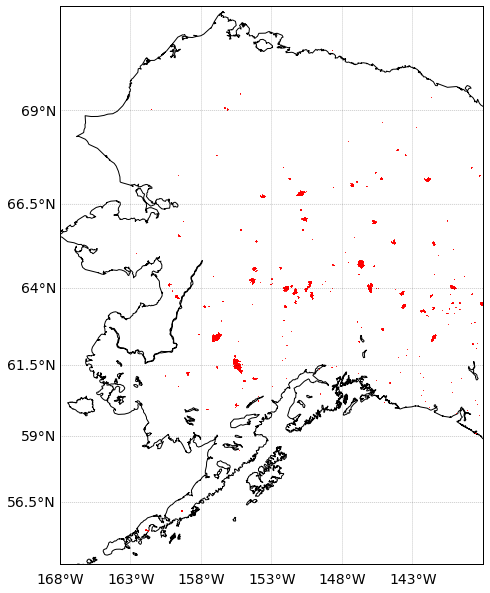

In [10]:
# Figure 1a: Alaska with a heatmap of detections for 2013
year = 2013

annual_fires = ak_modis[ak_modis.year==year]   # Get fires for this year
matplotlib.rcParams.update({'font.size': 14})  # Make font bigger
plt.figure(figsize=(10,10))  # Make figure bigger
ak_bb = [54, 71.5, -168, -138]   # Extended bounding box to show all of Alaska

# Basemap is a python library for plotting maps. It's kind of annoying to use sometimes and
# I've heard there are better geometry plotting packages, but it's easy to use and it's what
# our collaborator Yang uses.
mp = Basemap(projection="merc",
             lat_0=ak_bb[0], lon_0=ak_bb[0],
             llcrnrlat=ak_bb[0],
             llcrnrlon=ak_bb[2],
             urcrnrlat=ak_bb[1],
             urcrnrlon=ak_bb[3],
             resolution='i')

mp.drawcoastlines()  # Draw coastlines
#mp.etopo()  # Draw topography if desired
#mp.shadedrelief()   # Draw simpler version of topography if desired
# Get map coordinates for our fire detections
mp_lons, mp_lats = mp(np.array(annual_fires.lon), np.array(annual_fires.lat))
mp.plot(mp_lons, mp_lats, 'r.', markersize=1)
# Draw latitude/longitude lines
parallels = np.arange(ak_bb[0],ak_bb[1],2.5)
mp.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.2)
meridians = np.arange(ak_bb[2],ak_bb[3],5.)
mp.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.2)
plt.show()